In [2]:
import gdown

url = "https://drive.google.com/uc?id=1_KuJpF7AKVbytIld7V37Gf5afMHcwxLk"
output = "NUTS_posterior_samples.pkl"
gdown.download(url, output, quiet=False)
import pickle

with open("NUTS_posterior_samples.pkl", "rb") as f:
    loaded_samples = pickle.load(f)


Downloading...
From (original): https://drive.google.com/uc?id=1_KuJpF7AKVbytIld7V37Gf5afMHcwxLk
From (redirected): https://drive.google.com/uc?id=1_KuJpF7AKVbytIld7V37Gf5afMHcwxLk&confirm=t&uuid=8b8c7733-275f-4475-a1b7-7846994c4661
To: d:\Maths_Y4\Project\Bayesian-Neural-Network-Project\Boston Dataset Experiments\Obesity\NUTS_posterior_samples.pkl
100%|██████████| 205M/205M [03:44<00:00, 914kB/s]  


In [3]:
import torch
import matplotlib.pyplot as plt

In [5]:
def find_top_covariances(loaded_samples, top_n=5):
    covariances = []
    
    weight_keys = [k for k in loaded_samples.keys() if "weight" in k]
    bias_keys = [k for k in loaded_samples.keys() if "bias" in k]
    
    for w_key in weight_keys:
        weights = loaded_samples[w_key]  # Shape: (n_samples, output_dim, input_dim)
        output_dim, input_dim = weights.shape[1:]
        
        for b_key in bias_keys:
            biases = loaded_samples[b_key]  # Shape: (n_samples, output_dim)
            
            for i in range(output_dim):
                for j in range(input_dim):
                    for k in range(biases.shape[1]):  # Iterate over output_dim
                        cov_matrix = torch.cov(torch.stack([weights[:, i, j], biases[:, k]], dim=0))
                        cov = cov_matrix[0, 1].item()
                        
                        covariances.append((cov, w_key, b_key, i, j, k))
    
    covariances.sort(reverse=True, key=lambda x: x[0])
    return covariances[:top_n]

best_pairs = find_top_covariances(loaded_samples, top_n=20)
for cov, w_key, b_key, i, j, k in best_pairs:
    print(f"Covariance: {cov} between {w_key}[{i}, {j}] and {b_key}[{k}]")

Covariance: 0.33332759141921997 between layers.0.weight[7, 2] and layers.0.bias[7]
Covariance: 0.27260318398475647 between layers.2.weight[6, 8] and layers.1.bias[8]
Covariance: 0.25913989543914795 between layers.2.weight[6, 6] and layers.1.bias[6]
Covariance: 0.2589578628540039 between layers.2.weight[6, 2] and layers.1.bias[2]
Covariance: 0.2554457187652588 between layers.2.weight[6, 9] and layers.1.bias[9]
Covariance: 0.2504938244819641 between layers.2.weight[6, 4] and layers.1.bias[4]
Covariance: 0.25026658177375793 between layers.2.weight[6, 7] and layers.1.bias[7]
Covariance: 0.2500526010990143 between layers.2.weight[6, 0] and layers.1.bias[0]
Covariance: 0.2492234706878662 between layers.2.weight[6, 3] and layers.1.bias[3]
Covariance: 0.2473478615283966 between layers.2.weight[6, 5] and layers.1.bias[5]
Covariance: 0.23910318315029144 between layers.0.weight[8, 2] and layers.0.bias[8]
Covariance: 0.23417465388774872 between layers.2.weight[6, 1] and layers.1.bias[1]
Covariance

In [7]:
def find_top_correlations(loaded_samples, top_n=5):
    correlations = []
    
    weight_keys = [k for k in loaded_samples.keys() if "weight" in k]
    bias_keys = [k for k in loaded_samples.keys() if "bias" in k]
    
    for w_key in weight_keys:
        weights = loaded_samples[w_key]  # Shape: (n_samples, output_dim, input_dim)
        output_dim, input_dim = weights.shape[1:]
        
        for b_key in bias_keys:
            biases = loaded_samples[b_key]  # Shape: (n_samples, output_dim)
            
            for i in range(output_dim):
                for j in range(input_dim):
                    for k in range(biases.shape[1]):  # Iterate over output_dim
                        corr_matrix = torch.corrcoef(torch.stack([weights[:, i, j], biases[:, k]], dim=0))
                        corr = corr_matrix[0, 1].item()
                        
                        correlations.append((corr, w_key, b_key, i, j, k))
    
    correlations.sort(reverse=True, key=lambda x: x[0])
    return correlations[:top_n]

best_pairs = find_top_correlations(loaded_samples, top_n=10)
for cov, w_key, b_key, i, j, k in best_pairs:
    print(f"Correlation: {cov} between {w_key}[{i}, {j}] and {b_key}[{k}]")

Correlation: 0.3714183568954468 between layers.2.weight[6, 8] and layers.1.bias[8]
Correlation: 0.36327943205833435 between layers.2.weight[6, 6] and layers.1.bias[6]
Correlation: 0.3596702516078949 between layers.2.weight[6, 2] and layers.1.bias[2]
Correlation: 0.3571675419807434 between layers.2.weight[6, 9] and layers.1.bias[9]
Correlation: 0.35523685812950134 between layers.2.weight[6, 0] and layers.1.bias[0]
Correlation: 0.3544197380542755 between layers.2.weight[6, 3] and layers.1.bias[3]
Correlation: 0.35350117087364197 between layers.2.weight[6, 7] and layers.1.bias[7]
Correlation: 0.35174429416656494 between layers.2.weight[6, 4] and layers.1.bias[4]
Correlation: 0.3449966609477997 between layers.2.weight[6, 5] and layers.1.bias[5]
Correlation: 0.3382471799850464 between layers.2.weight[6, 1] and layers.1.bias[1]


## HMC

In [3]:
# Load dictionary from the pickle file
import pickle
with open('post_samples.pkl', 'rb') as f:
    loaded_samples = pickle.load(f)

In [5]:
def find_top_covariances(loaded_samples, top_n=5):
    covariances = []
    
    weight_keys = [k for k in loaded_samples.keys() if "weight" in k]
    bias_keys = [k for k in loaded_samples.keys() if "bias" in k]
    
    for w_key in weight_keys:
        weights = loaded_samples[w_key]  # Shape: (n_samples, output_dim, input_dim)
        output_dim, input_dim = weights.shape[1:]
        
        for b_key in bias_keys:
            biases = loaded_samples[b_key]  # Shape: (n_samples, output_dim)
            
            for i in range(output_dim):
                for j in range(input_dim):
                    for k in range(biases.shape[1]):  # Iterate over output_dim
                        cov_matrix = torch.cov(torch.stack([weights[:, i, j], biases[:, k]], dim=0))
                        cov = cov_matrix[0, 1].item()
                        
                        covariances.append((cov, w_key, b_key, i, j, k))
    
    covariances.sort(reverse=True, key=lambda x: x[0])
    return covariances[:top_n]

best_pairs = find_top_covariances(loaded_samples, top_n=20)
for cov, w_key, b_key, i, j, k in best_pairs:
    print(f"Covariance: {cov} between {w_key}[{i}, {j}] and {b_key}[{k}]")

Covariance: 0.9226664900779724 between layers.1.weight[4, 1] and layers.0.bias[2]
Covariance: 0.9042421579360962 between layers.0.weight[1, 1] and layers.0.bias[2]
Covariance: 0.6412150263786316 between layers.1.weight[7, 9] and layers.0.bias[9]
Covariance: 0.5773876905441284 between layers.1.weight[4, 9] and layers.0.bias[0]
Covariance: 0.5452324748039246 between layers.0.weight[9, 1] and layers.0.bias[0]
Covariance: 0.5276114344596863 between layers.0.weight[9, 1] and layers.0.bias[8]
Covariance: 0.5148876905441284 between layers.1.weight[4, 9] and layers.0.bias[8]
Covariance: 0.5034401416778564 between layers.1.weight[4, 1] and layers.0.bias[9]
Covariance: 0.4728175103664398 between layers.0.weight[1, 1] and layers.0.bias[9]
Covariance: 0.4525747001171112 between layers.0.weight[8, 1] and layers.0.bias[9]
Covariance: 0.44908639788627625 between layers.2.weight[1, 7] and layers.0.bias[5]
Covariance: 0.4303789734840393 between layers.1.weight[4, 8] and layers.0.bias[9]
Covariance: 0.4

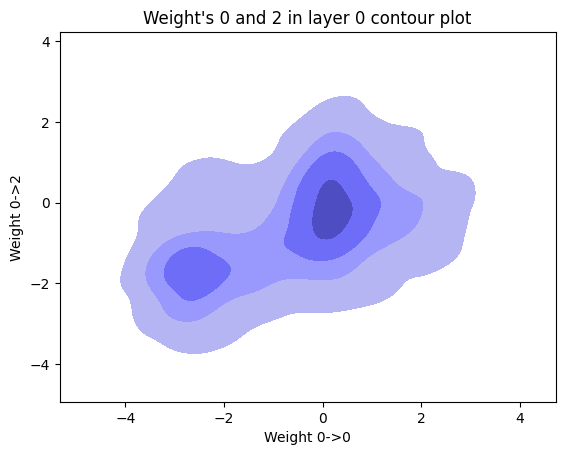

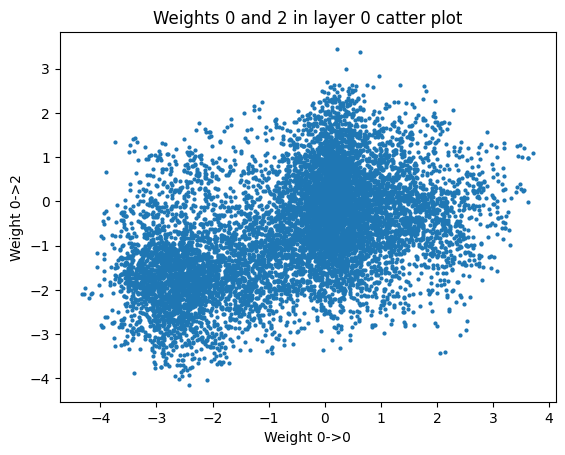

In [41]:
# These are the joint density plots of the 5 highest covariance pairs, in descending order

x=loaded_samples['layers.1.weight'][:,4,1]
y=loaded_samples['layers.0.bias'][:,2]

# x=loaded_samples['layers.0.weight'][:,1,1]
# y=loaded_samples['layers.0.bias'][:,2]

# x=loaded_samples['layers.1.weight'][:,7,9]
# y=loaded_samples['layers.0.bias'][:,0]

# x=loaded_samples['layers.1.weight'][:,4,9]
# y=loaded_samples['layers.0.bias'][:,0]

# x=loaded_samples['layers.0.weight'][:,9,1]
# y=loaded_samples['layers.0.bias'][:,0]

import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(x = x, y = y, fill = True, levels = [0.05, 0.3, 0.6, 0.9, 1], color = 'blue')
plt.xlabel("Weight 0->0")
plt.ylabel("Weight 0->2")
# plt.xlim([-0.4,0.6])
# plt.ylim([-0.2,0.7])
plt.title("Weight's 0 and 2 in layer 0 contour plot")
plt.show()

plt.scatter(x = x, y = y, s = 4)
# plt.xlim([-1.3,0.3])
# plt.ylim([-0.1,0.3])
plt.xlabel("Weight 0->0")
plt.ylabel("Weight 0->2")
plt.title("Weights 0 and 2 in layer 0 catter plot")
plt.show()

In [39]:
def find_top_correlations(loaded_samples, top_n=5):
    correlations = []
    
    weight_keys = [k for k in loaded_samples.keys() if "weight" in k]
    bias_keys = [k for k in loaded_samples.keys() if "bias" in k]
    
    for w_key in weight_keys:
        weights = loaded_samples[w_key]  # Shape: (n_samples, output_dim, input_dim)
        output_dim, input_dim = weights.shape[1:]
        
        for b_key in bias_keys:
            biases = loaded_samples[b_key]  # Shape: (n_samples, output_dim)
            
            for i in range(output_dim):
                for j in range(input_dim):
                    for k in range(biases.shape[1]):  # Iterate over output_dim
                        corr_matrix = torch.corrcoef(torch.stack([weights[:, i, j], biases[:, k]], dim=0))
                        corr = corr_matrix[0, 1].item()
                        
                        correlations.append((corr, w_key, b_key, i, j, k))
    
    correlations.sort(reverse=True, key=lambda x: x[0])
    return correlations[:top_n]

best_pairs = find_top_correlations(loaded_samples, top_n=5)
for cov, w_key, b_key, i, j, k in best_pairs:
    print(f"Correlation: {cov} between {w_key}[{i}, {j}] and {b_key}[{k}]")

Correlation: 0.49207803606987 between layers.0.weight[1, 1] and layers.0.bias[2]
Correlation: 0.48763033747673035 between layers.1.weight[4, 1] and layers.0.bias[2]
Correlation: 0.4576738476753235 between layers.1.weight[7, 9] and layers.0.bias[9]
Correlation: 0.42443880438804626 between layers.0.weight[5, 4] and layers.0.bias[5]
Correlation: 0.4114227592945099 between layers.0.weight[2, 4] and layers.0.bias[2]


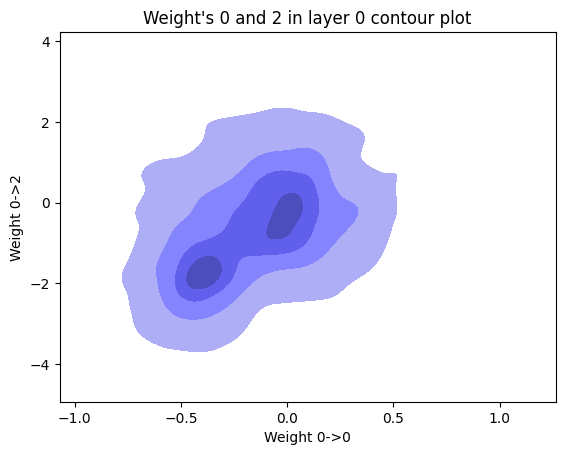

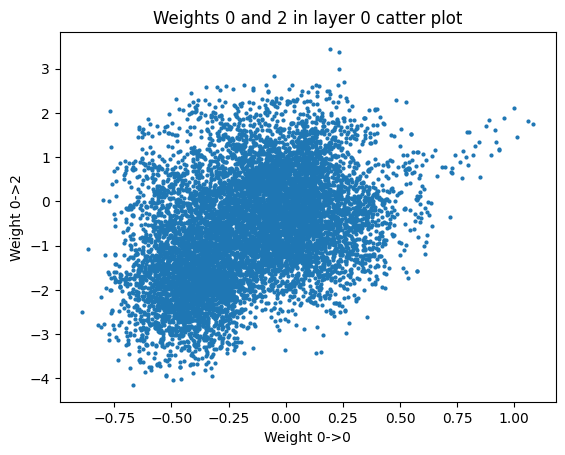

In [47]:
# These are the joint density plots of the 5 highest correlation pairs, in descending order

# x=loaded_samples['layers.0.weight'][:,1,1]
# y=loaded_samples['layers.0.bias'][:,2]

# x=loaded_samples['layers.1.weight'][:,4,1]
# y=loaded_samples['layers.0.bias'][:,2]

# x=loaded_samples['layers.1.weight'][:,7,9]
# y=loaded_samples['layers.0.bias'][:,9]

# x=loaded_samples['layers.0.weight'][:,5,4]
# y=loaded_samples['layers.0.bias'][:,5]

x=loaded_samples['layers.0.weight'][:,2,4]
y=loaded_samples['layers.0.bias'][:,2]

import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(x = x, y = y, fill = True, levels = [0.05, 0.3, 0.6, 0.9, 1], color = 'blue')
plt.xlabel("Weight 0->0")
plt.ylabel("Weight 0->2")
# plt.xlim([-0.4,0.6])
# plt.ylim([-0.2,0.7])
plt.title("Weight's 0 and 2 in layer 0 contour plot")
plt.show()

plt.scatter(x = x, y = y, s = 4)
# plt.xlim([-1.3,0.3])
# plt.ylim([-0.1,0.3])
plt.xlabel("Weight 0->0")
plt.ylabel("Weight 0->2")
plt.title("Weights 0 and 2 in layer 0 catter plot")
plt.show()

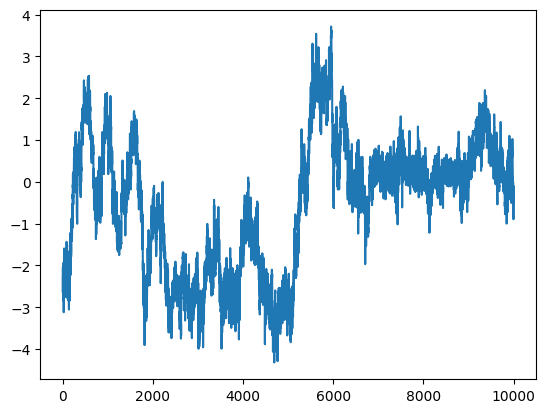

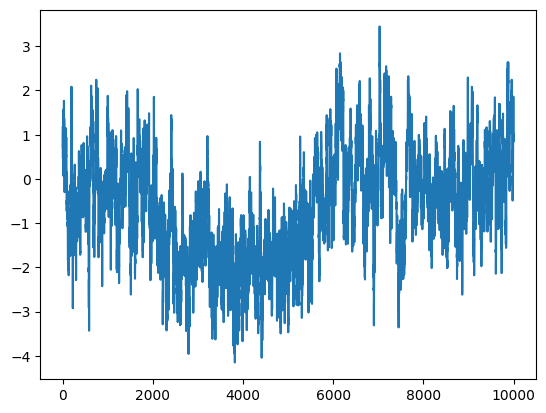

In [ ]:
# evaluate mixing
def hmc_lines_layer0_w(i, j):
    y = loaded_samples['layers.0.weight'][:,i,j].detach().numpy()
    n = len(y)
    x = np.arange(1, n+1)
    plt.plot(x, y)
    plt.show()

def hmc_lines_layer1_w(i, j):
    y = loaded_samples['layers.1.weight'][:,i,j].detach().numpy()
    n = len(y)
    x = np.arange(1, n+1)
    plt.plot(x, y)
    plt.show()

def hmc_lines_layer2_w(i, j):
    y = loaded_samples['layers.2.weight'][:,i,j].detach().numpy()
    n = len(y)
    x = np.arange(1, n+1)
    plt.plot(x, y)
    plt.show()

def hmc_lines_layer0_b(i):
    y = loaded_samples['layers.0.bias'][:,i].detach().numpy()
    n = len(y)
    x = np.arange(1, n+1)
    plt.plot(x, y)
    plt.show()

def hmc_lines_layer1_b(i):
    y = loaded_samples['layers.1.bias'][:,i].detach().numpy()
    n = len(y)
    x = np.arange(1, n+1)
    plt.plot(x, y)
    plt.show()

def hmc_lines_layer2_b(i):
    y = loaded_samples['layers.2.bias'][:,i].detach().numpy()
    n = len(y)
    x = np.arange(1, n+1)
    plt.plot(x, y)
    plt.show()

hmc_lines_layer1_w(4,1)

hmc_lines_layer0_b(2)

## Slang

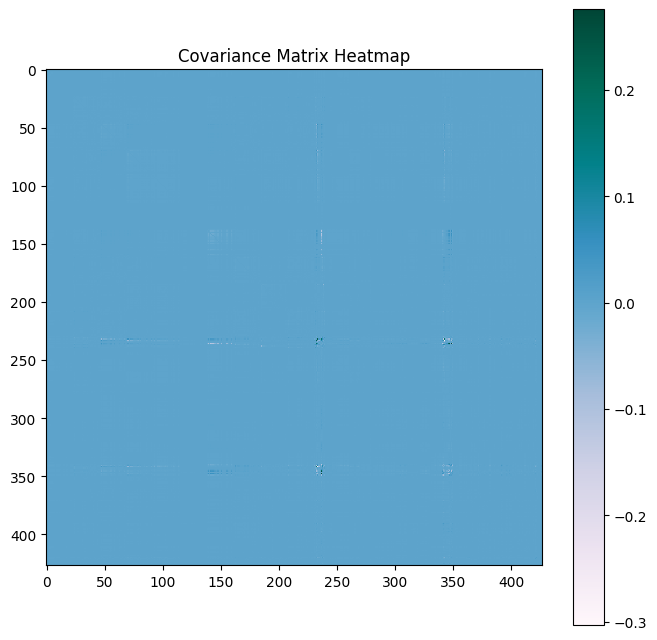

In [81]:
import pickle
import torch
import matplotlib.pyplot as plt
import numpy as np

path = r"D:\Maths_Y4\Project\Bayesian-Neural-Network-Project\Rebuilding_Slang\results_dict.pkl"

with open(path, 'rb') as f:
    results_dict = pickle.load(f)

## I believe this is an unstable method
param_means = results_dict['optimizer']['state']['mean']
prec_factor = results_dict['optimizer']['state']['prec_factor']
prec_diag = results_dict['optimizer']['state']['prec_diag']
# Using woodbury matrix identity
D_inv = torch.diag(1/prec_diag.squeeze())
middle_term = torch.linalg.inv(torch.eye(prec_factor.size(1)) + prec_factor.T @ (D_inv @ prec_factor))
cov_matrix = D_inv - ((D_inv @ prec_factor) @ (middle_term @(prec_factor.T @ D_inv)))
cov_matrix.fill_diagonal_(0)

cov_matrix = cov_matrix.detach().cpu().numpy()

# cov_matrix[330:350,330:350] = np.zeros((20,20))
plt.figure(figsize=(8, 8)) 
plt.imshow((cov_matrix), cmap='PuBuGn', interpolation='nearest') 
plt.colorbar() 
plt.title("Covariance Matrix Heatmap") 
plt.show()


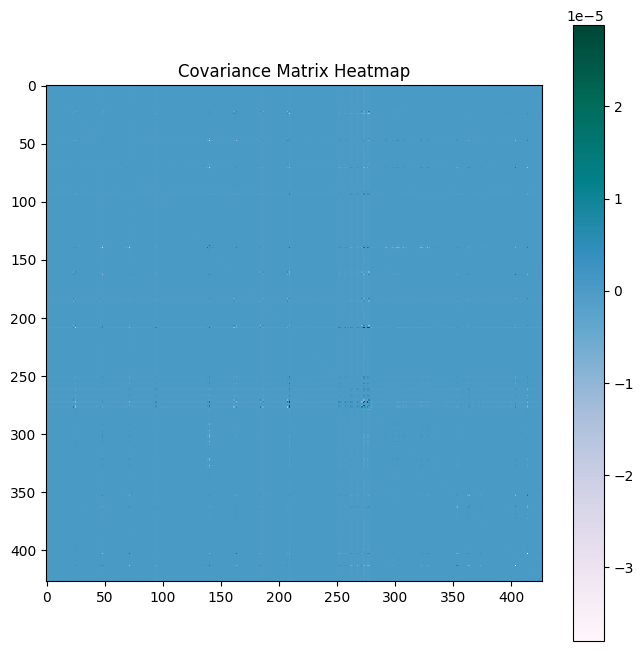

In [80]:
cov_attempt = torch.linalg.pinv(prec_factor @ prec_factor.t() + torch.diag(prec_diag))
cov_attempt.fill_diagonal_(0)

plt.figure(figsize=(8, 8)) 
plt.imshow((cov_attempt), cmap='PuBuGn', interpolation='nearest') 
plt.colorbar() 
plt.title("Covariance Matrix Heatmap") 
plt.show()


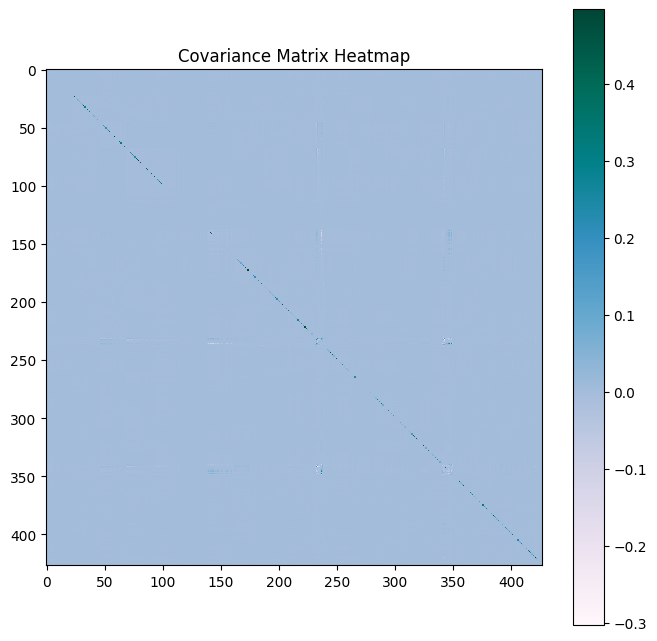

In [63]:
D = torch.diag(prec_diag.squeeze())  # Diagonal matrix D
prec = prec_factor @ prec_factor.T + D  # Precision matrix

# Cholesky decomposition (ensure the matrix is positive-definite)
L = torch.linalg.cholesky(prec)

# Inverse of the precision matrix using Cholesky decomposition
precision_inv = torch.linalg.inv(L).T @ torch.linalg.inv(L)
precision_inv[precision_inv > 0.5] = 0

plt.figure(figsize=(8, 8)) 
plt.imshow((precision_inv), cmap='PuBuGn', interpolation='nearest') 
plt.colorbar() 
plt.title("Covariance Matrix Heatmap") 
plt.show()


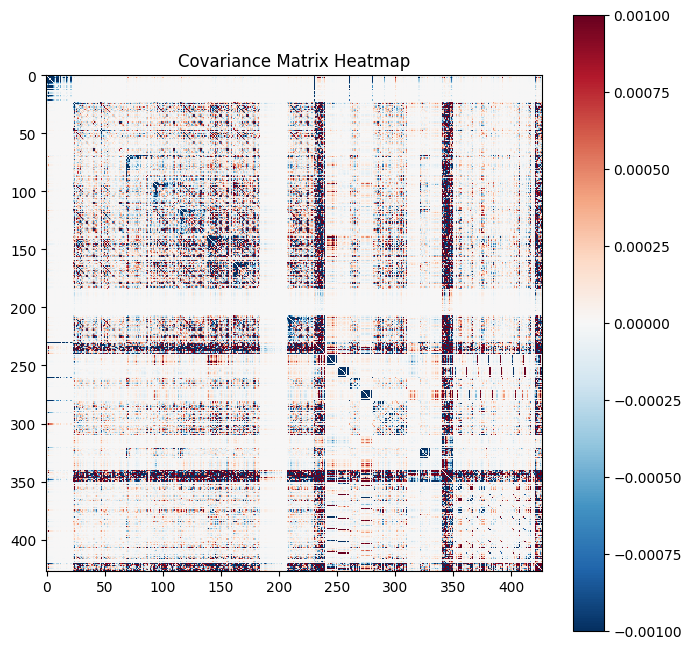

In [124]:
import pickle
import torch
import matplotlib.pyplot as plt
import numpy as np

path = r"D:\Maths_Y4\Project\Bayesian-Neural-Network-Project\Rebuilding_Slang\results_dict.pkl"

with open(path, 'rb') as f:
    results_dict = pickle.load(f)

## I believe this is an unstable method
param_means = results_dict['optimizer']['state']['mean']
prec_factor = results_dict['optimizer']['state']['prec_factor']
prec_diag = results_dict['optimizer']['state']['prec_diag']
# Using woodbury matrix identity

d_inv = torch.diag(1/prec_diag.squeeze()) # vector of diagonal inverse

Kinv = torch.eye(prec_factor.size(1)) + prec_factor.t() @ (d_inv @ prec_factor)
s1 = (d_inv @ prec_factor).t()
s2 = torch.linalg.solve(Kinv, s1)
cov_matrix = ((d_inv) - (d_inv@prec_factor)@(s2))

cov_matrix.fill_diagonal_(0)

cov_matrix = cov_matrix.detach().cpu().numpy()
threshold = 0.001
clipped_cov_matrix = np.clip(cov_matrix, -threshold, threshold)

# cov_matrix[330:350,330:350] = np.zeros((20,20))
plt.figure(figsize=(8, 8)) 
plt.imshow((clipped_cov_matrix), cmap='RdBu_r', interpolation='nearest',vmin=np.min(clipped_cov_matrix), vmax=np.max(clipped_cov_matrix)) 
plt.colorbar() 
plt.title("Covariance Matrix Heatmap") 
plt.show()


In [139]:
i, j = 353, 353  # For example, find the (2, 3)-th entry of A^-1

e_j = torch.zeros(cov_matrix.shape[0])
e_j[j] = 1
x = torch.linalg.solve(prec_factor@prec_factor.T + torch.diag(prec_diag.squeeze()), e_j)

inverse_element = x[i]
